<a href="https://colab.research.google.com/github/chitra-psg/rossmann_sales_prediction/blob/main/Rossman_Sales_Prediction_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Rossman Sales Forecasting**

***Problem*** : Rossmann is a European drug distributor which operates over 3,000 drug stores across seven European countries. Since a lot of drugs come with a short shelf life, that is, they do not have a long expiry date, it becomes imperative for Rossmann to accurately forecast sales at their individual stores. Currently, the forecasting is taken care of by the store managers who are tasked with forecasting daily sales for the next six weeks.As expected, store sales are influenced by many factors, including promotional campaigns, competition, state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances and intuitions, the accuracy of the forecasts is quite varied.

*Build a forecasting model to forecast the daily sales for the next six weeks*

In [1]:
#importing important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

### **Data Processing**

#### **Source Data**

In [2]:
store = pd.read_csv('store.csv')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [3]:
sales = pd.read_csv('train.csv')
sales.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
store_sales_full = sales.merge(right=store, on='Store', how='left')
store_sales_full.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
store_sales_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [7]:
store_sales  = store_sales_full[~((store_sales_full.Open==0) & (store_sales_full.Sales==0))]

In [8]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844392 non-null  int64  
 1   DayOfWeek                  844392 non-null  int64  
 2   Date                       844392 non-null  object 
 3   Sales                      844392 non-null  int64  
 4   Customers                  844392 non-null  int64  
 5   Open                       844392 non-null  int64  
 6   Promo                      844392 non-null  int64  
 7   StateHoliday               844392 non-null  object 
 8   SchoolHoliday              844392 non-null  int64  
 9   StoreType                  844392 non-null  object 
 10  Assortment                 844392 non-null  object 
 11  CompetitionDistance        842206 non-null  float64
 12  CompetitionOpenSinceMonth  575773 non-null  float64
 13  CompetitionOpenSinceYear   5

In [9]:
#Check nulls for null treatment
store_sales.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2186
CompetitionOpenSinceMonth    268619
CompetitionOpenSinceYear     268619
Promo2                            0
Promo2SinceWeek              423307
Promo2SinceYear              423307
PromoInterval                423307
dtype: int64

In [10]:
#Competition Details
store_sales[((~ store_sales['CompetitionDistance'].isna()) & store_sales['CompetitionOpenSinceMonth'].isna())]
# Although distance is available but no start date avaialble

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,5,2015-07-31,8959,962,1,1,0,1,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,5,2015-07-31,8821,568,1,1,0,0,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,5,2015-07-31,10231,979,1,1,0,1,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,5,2015-07-31,8234,718,1,1,0,1,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,5,2015-07-31,6566,633,1,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016606,512,2,2013-01-01,2646,625,1,0,a,1,b,b,590.0,NaN,NaN,1,5.0,2013.0,"Mar,Jun,Sept,Dec"
1016624,530,2,2013-01-01,2907,532,1,0,a,1,a,c,18160.0,NaN,NaN,0,NaN,NaN,NaN
1016656,562,2,2013-01-01,8498,1675,1,0,a,1,b,c,1210.0,NaN,NaN,0,NaN,NaN,NaN
1016863,769,2,2013-01-01,5035,1248,1,0,a,1,b,b,840.0,NaN,NaN,1,48.0,2012.0,"Jan,Apr,Jul,Oct"


In [11]:
#Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
store_sales.Promo2.value_counts()

0    423307
1    421085
Name: Promo2, dtype: int64

#### ***Findings*** :

1. When no Promo (Promo2 =0) then no Promo related details available in Promo2SinceWeek , Promo2SinceYear and PromoInterval
2. Object data type columns Date, State Holiday need to convert.
3. Null in competition fields like CompetitionOpenSinceMonth and CompetitionOpenSinceYear indicate information is missing and needs to be fixed.

In [12]:

# Convert Date to a date-time-object
store_sales['Date'] = pd.to_datetime(store_sales['Date'], format='%Y-%m-%d')

store_sales.StateHoliday = store_sales.StateHoliday.replace(0,'0')

store_sales = store_sales.astype({
    'CompetitionOpenSinceMonth': pd.Int8Dtype(),
    'CompetitionOpenSinceYear': pd.Int16Dtype(),
    'Promo2SinceWeek': pd.Int8Dtype(),
    'Promo2SinceYear': pd.Int16Dtype()
})


#NULL Treatment - we will set it as -1 to indicate there was no promotion.
#Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
store_sales['Promo2SinceWeek'] = store_sales['Promo2SinceWeek'].replace(np.nan,-1).astype(int)
store_sales['Promo2SinceYear'] = store_sales['Promo2SinceYear'].replace(np.nan,-1).astype(int)
store_sales['PromoInterval'] = store_sales['PromoInterval'].replace(np.nan,'N/A')

#Competition Distance and other competitor related fields values not available would indicate no competitor so can fill with -1
store_sales['CompetitionDistance'] = store_sales['CompetitionDistance'].replace(np.nan,-1).astype(int)
store_sales['CompetitionOpenSinceMonth'] = store_sales['CompetitionOpenSinceMonth'].replace(np.nan,-1).astype(int)
store_sales['CompetitionOpenSinceYear'] = store_sales['CompetitionOpenSinceYear'].replace(np.nan,-1).astype(int)

#store_sales['Promo'] = store_sales['Promo'].astype(bool)
#store_sales['Promo2'] = store_sales['Promo2'].astype(bool)

store_sales['PromoInterval'] = store_sales['PromoInterval'].replace(np.nan,'N/A')


store_sales['Year'] = store_sales['Date'].dt.year
store_sales['WeekofYear'] = store_sales['Date'].dt.weekofyear
store_sales['Month'] = store_sales['Date'].dt.month
store_sales['WeekofYear'] = store_sales['Date'].dt.weekofyear



In [13]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int64         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  int64         
 4   Customers                  844392 non-null  int64         
 5   Open                       844392 non-null  int64         
 6   Promo                      844392 non-null  int64         
 7   StateHoliday               844392 non-null  object        
 8   SchoolHoliday              844392 non-null  int64         
 9   StoreType                  844392 non-null  object        
 10  Assortment                 844392 non-null  object        
 11  CompetitionDistance        844392 non-null  int64  

In [14]:
store_sales.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'WeekofYear', 'Month'],
      dtype='object')

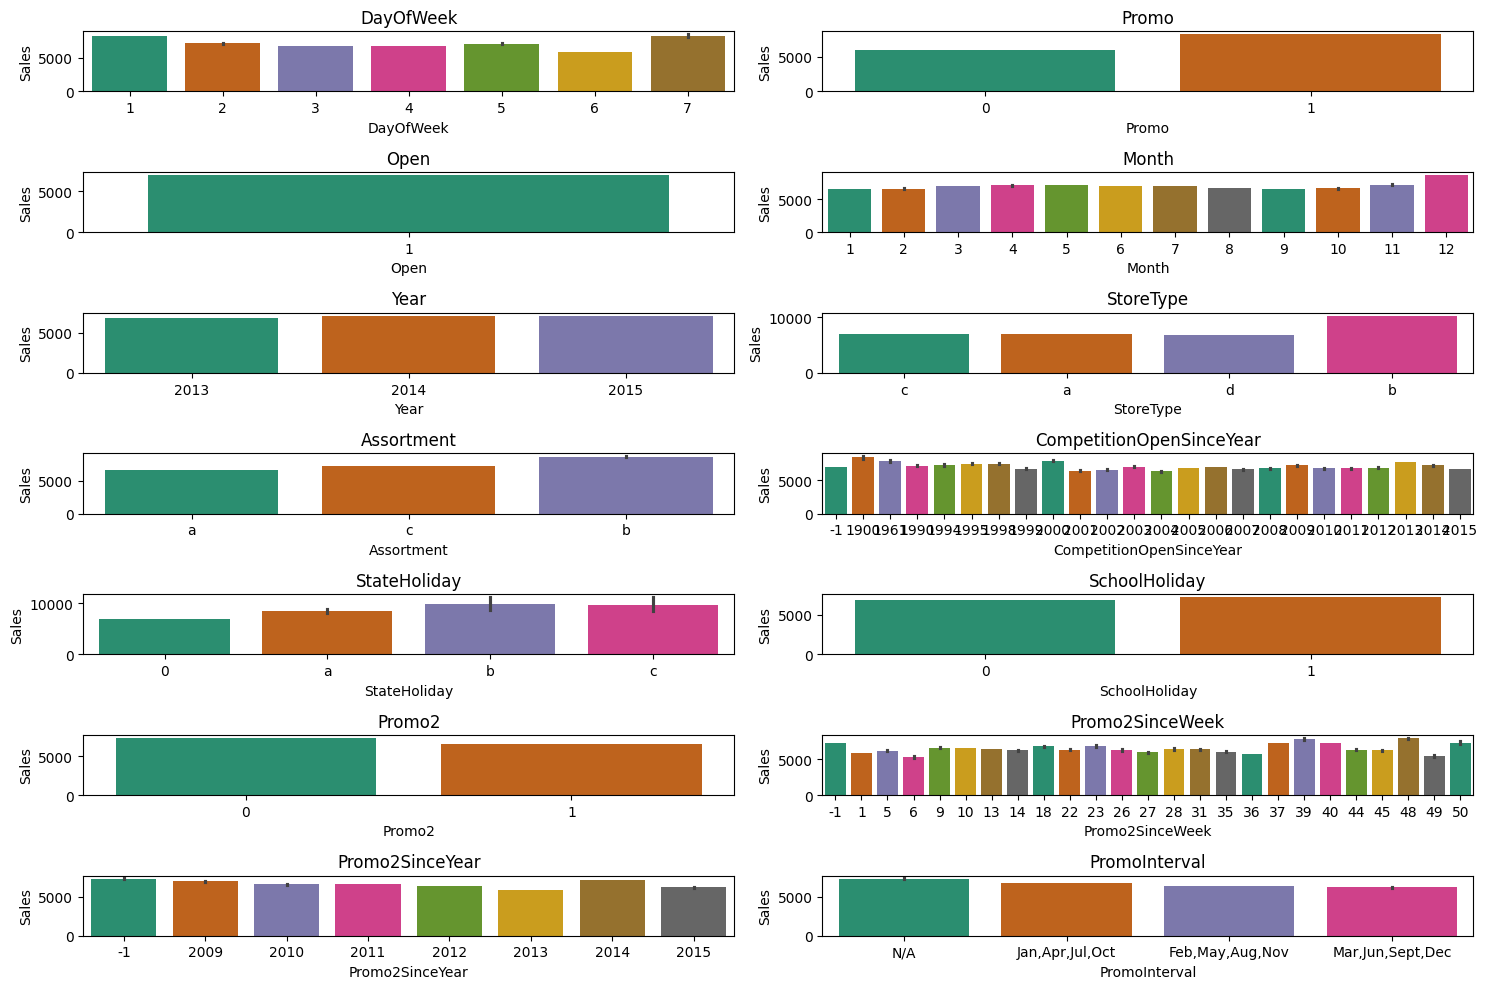

In [15]:
# Select categorical columns
sales_categorical_cols = ['DayOfWeek', 'Promo','Open','Month' ,'Year','StoreType','Assortment', 'CompetitionOpenSinceYear', 'StateHoliday','SchoolHoliday','Promo2','Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

# Define rows and columns for subplots
rows = int(np.ceil(len(sales_categorical_cols) / 2))  # Assuming 2 columns per row
cols = min(2, len(sales_categorical_cols))

# Create figure and subplots
fig, axs = plt.subplots(rows, cols, figsize=(15, 10), squeeze=True)  # Ensure 1D array of subplots

for i, col in enumerate(sales_categorical_cols):
    sns.barplot(x=col, y='Sales', data=store_sales, ax=axs.ravel()[i], palette="Dark2")
    axs.ravel()[i].set_title(col)
    axs.ravel()[i].xaxis.set_label_text(col)  # Access and set label on the correct subplot's axis

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()


**Inferences**
> Almost nil sales on Sunday and high sales on Monday

> Higher sales when there is promotion

> Assortment b has higher sales

> Slight increase in sales when school holiday

> Almost nil sales on State Holiday a,b,c






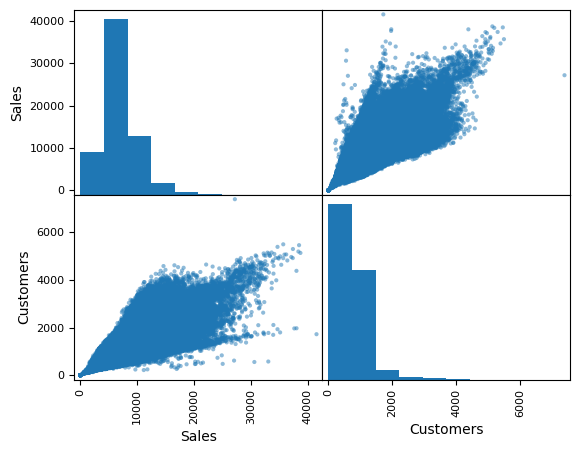

In [16]:
#Sales_Customers
from pandas.plotting import scatter_matrix
attributes = ["Sales", "Customers"]
scatter_matrix(store_sales[attributes]);

Findings
1. Increase in customer increases sales/increase in sales increases customers. Spurious relationship?

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming grouped_data is a DataFrame
grouped_data = store_sales.groupby(['Store', 'Promo'])['Sales'].sum().unstack()

# Filter stores
selected_stores = [1, 3, 8, 9, 13, 25, 29, 31, 46]
grouped_data = grouped_data[grouped_data.index.isin(selected_stores)]

# Calculate percentage based on the filtered grouped_data and round to 0 decimal places
percentage_data = (grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100).round(0)

# Plot the stacked bar chart
ax = percentage_data.plot(kind='bar', stacked=True, figsize=(10, 6))

# Display percentage labels on each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=8, color='white', weight='bold', padding=3)

# Set labels and title
plt.xlabel('Store and Promo')
plt.ylabel('Sales Percentage')
plt.title('Stacked Bar Chart of Sales Percentage by Store and Promo (Selected Stores)')

# Show the plot
plt.show()


Promotion has significant impact on the key stores identified

#### Detect Outliers in Sales and Customers

In [18]:
# detecting outliers
store_sales.describe(percentiles=[0.90,0.95,0.99])

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,WeekofYear,Month
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.0,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,558.422920,3.520361,6955.514291,762.728395,1.0,0.446352,0.193580,5443.847175,4.608370,1369.370279,0.498684,11.094802,1002.728749,2013.831937,23.646801,5.845738
std,321.731914,1.723689,3104.214680,401.227674,0.0,0.497114,0.395103,7804.253543,4.658448,936.023913,0.499999,15.691005,1006.374804,0.777260,14.389785,3.323931
min,1.000000,1.000000,0.000000,0.000000,1.0,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,2013.000000,1.000000,1.000000
50%,558.000000,3.000000,6369.000000,676.000000,1.0,0.000000,0.000000,2320.000000,4.000000,2006.000000,0.000000,-1.000000,-1.000000,2014.000000,23.000000,6.000000
90%,1004.000000,6.000000,10771.000000,1177.000000,1.0,1.000000,1.000000,15720.000000,11.000000,2013.000000,1.000000,40.000000,2013.000000,2015.000000,45.000000,11.000000
95%,1060.000000,6.000000,12668.000000,1440.000000,1.0,1.000000,1.000000,20390.000000,12.000000,2014.000000,1.000000,40.000000,2014.000000,2015.000000,49.000000,12.000000
99%,1104.000000,6.000000,17789.000000,2415.000000,1.0,1.000000,1.000000,36410.000000,12.000000,2015.000000,1.000000,45.000000,2014.000000,2015.000000,51.000000,12.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.0,1.000000,1.000000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000,2015.000000,52.000000,12.000000


In [19]:
store_sales_nooutlier = store_sales[store_sales['Sales'] <= store_sales['Sales'].quantile(.99)]
store_sales_nooutlier = store_sales_nooutlier[store_sales_nooutlier['Customers'] <= store_sales_nooutlier['Customers'].quantile(.99)]

In [20]:
data_store1 = store_sales_nooutlier[(store_sales_nooutlier.Store==1)]
print('Number of records for store 1: ', len(data_store1))
data_store3 = store_sales_nooutlier[(store_sales_nooutlier.Store==3)]
print('Number of records for store 3: ', len(data_store3))
data_store8 = store_sales_nooutlier[(store_sales_nooutlier.Store==8)]
print('Number of records for store 8: ', len(data_store8))
data_store9 = store_sales_nooutlier[(store_sales_nooutlier.Store==9)]
print('Number of records for store 9: ', len(data_store9))
#
data_store13 = store_sales_nooutlier[(store_sales_nooutlier.Store==13)]
print('Number of records for store 13: ', len(data_store13))
data_store25 = store_sales_nooutlier[(store_sales_nooutlier.Store==25)]
print('Number of records for store 25: ', len(data_store25))
data_store29 = store_sales_nooutlier[(store_sales_nooutlier.Store==29)]
print('Number of records for store 29: ', len(data_store29))
data_store31 = store_sales_nooutlier[(store_sales_nooutlier.Store==31)]
print('Number of records for store 31: ', len(data_store31))
#
data_store46 = store_sales_nooutlier[(store_sales_nooutlier.Store==46)]
print('Number of records for store 46: ', len(data_store46))

store_dfs = [data_store1, data_store3, data_store8, data_store9, data_store13, data_store25, data_store29, data_store31, data_store46 ]
label_dfs = ['store1', 'store3', 'store8', 'store9', 'store13', 'store25','store29', 'store31', 'store46']
index = [1,3,8,9,13,25,29,31,46]


left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.8   # the amount of height reserved for white space between subplots


Number of records for store 1:  781
Number of records for store 3:  779
Number of records for store 8:  784
Number of records for store 9:  779
Number of records for store 13:  621
Number of records for store 25:  695
Number of records for store 29:  779
Number of records for store 31:  784
Number of records for store 46:  622


In [21]:
def plot_store_trend(title, xaxis, yaxis, chart_type,order_list =None):

  # PROMO
  fig, axis = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(10,6))
  fig.suptitle(title)
  fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

  i = 0
  for x in range (0,3):
      for y in range (0,3):
          #i = x + y + int(incr)
          j = index[i]
          label =  label_dfs[i]
          d = store_dfs[i]
          axis[x,y].title.set_text(label)
          if chart_type == 'bar':
            if order_list is None:
              sns.barplot(x=xaxis, y=yaxis, data=d, ax=axis[x,y], palette="Dark2")
            else:
              sns.barplot(x=xaxis, y=yaxis, data=d, ax=axis[x,y], order = order_list, palette="Dark2")

          if chart_type == 'line':
              sns.lineplot(x=xaxis, y=yaxis, data=d, ax=axis[x,y], palette="Dark2")
          elif chart_type == 'box':
              sns.boxplot(x=d[xaxis],whis=1.5, palette="Dark2")
          i = i + 1

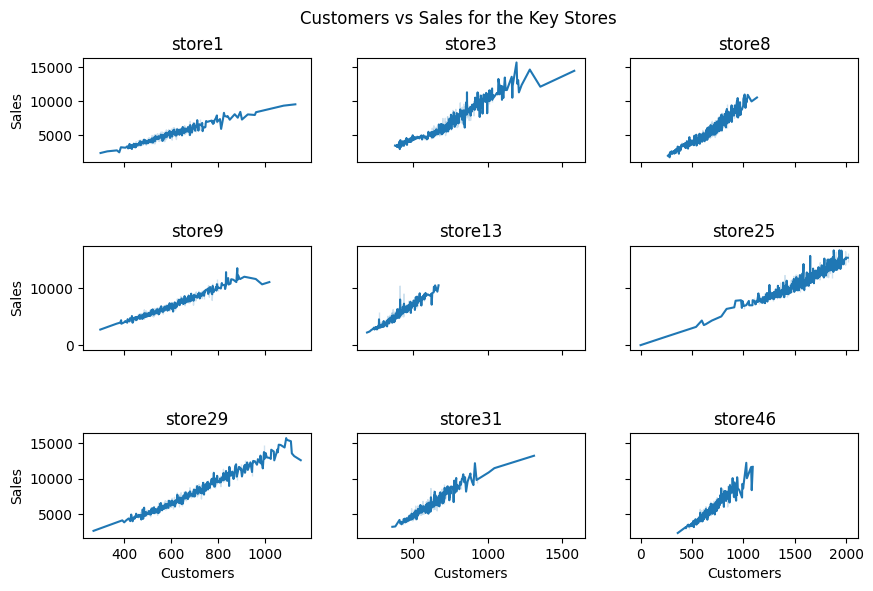

In [22]:
plot_store_trend('Customers vs Sales for the Key Stores', 'Customers', 'Sales', 'line')

In [ ]:
plot_store_trend('Promo vs Non Promo Sales for Key Stores', 'Promo', 'Sales', 'bar')

In [ ]:
plot_store_trend('Promo2 vs ALL Nine Stores Sales data', 'SchoolHoliday', 'Sales', 'bar')

In [ ]:
 sns.lineplot(x='Month', y='Sales', data=store_sales_nooutlier, palette="Dark2")

In [ ]:
# box-plot creation for variious variables w.r.t sales
plt.figure(figsize=(20,20))
plt.subplot(4,4,1)
sns.boxplot(x = store_sales_nooutlier.DayOfWeek, y = store_sales_nooutlier.Sales, palette="Dark2")

plt.subplot(4,4,2)
sns.boxplot(x = store_sales_nooutlier.Promo2, y = store_sales_nooutlier.Sales, palette="Dark2")

plt.subplot(4,4,4)
sns.boxplot(x = store_sales_nooutlier.Promo, y = store_sales_nooutlier.Sales, palette="Dark2")

plt.subplot(4,4,5)
sns.boxplot(x = store_sales_nooutlier.StateHoliday, y = store_sales_nooutlier.Sales, palette="Dark2")

plt.subplot(4,4,6)
sns.boxplot(x = store_sales_nooutlier.SchoolHoliday, y = store_sales_nooutlier.Sales, palette="Dark2")

plt.subplot(4,4,7)
sns.boxplot(x = store_sales_nooutlier.StoreType, y = store_sales_nooutlier.Sales, palette="Dark2")

plt.subplot(4,4,8)
sns.boxplot(x = store_sales_nooutlier.Assortment, y = store_sales_nooutlier.Sales, palette="Dark2")

plt.subplot(4,4,9)
sns.boxplot(x = store_sales_nooutlier.CompetitionOpenSinceMonth, y = store_sales_nooutlier.Sales, palette="Dark2")

plt.subplot(4,4,10)
sns.boxplot(x = store_sales_nooutlier.Promo2SinceWeek, y = store_sales_nooutlier.Sales, palette="Dark2")
plt.xticks(rotation=90)

plt.subplot(4,4,11)
sns.boxplot(x = store_sales_nooutlier.Promo2SinceYear, y = store_sales_nooutlier.Sales, palette="Dark2")

plt.subplot(4,4,12)
sns.boxplot(x = store_sales_nooutlier.PromoInterval, y = store_sales_nooutlier.Sales, palette="Dark2")
plt.xticks(rotation=90)

plt.subplot(4,4,13)
sns.boxplot(x = store_sales_nooutlier.CompetitionOpenSinceYear, y = store_sales_nooutlier.Sales, palette="Dark2")

plt.xticks(rotation=90)
plt.show()

In [ ]:
# Let us plot average sales and pct change in sales
for i in range(0,9):
    d = store_dfs[i]
    label = label_dfs[i]
    # group by WeekofYear and get average sales, and precent change
    average_sales    = d.groupby('WeekofYear')["Sales"].mean()
    pct_change_sales = d.groupby('WeekofYear')["Sales"].sum().pct_change()

    fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

    # plot average sales over time(year-month)
    ax1 = average_sales.plot(legend=True, ax=axis1, marker='o', title=label + " - Average Sales Per Week.")
    ax1.set_xticks(range(len(average_sales)))
    ax1.set_xticklabels(average_sales.index.tolist())
    ax1.set_ylabel('Sales', size=12)

    # plot precent change for sales over time(year-month)
    ax2 = pct_change_sales.plot(legend=True, ax=axis2, marker='o', colormap="summer", title=label + " - Sales Percent Change Per Week.")
    plt.ylabel("Sales", size=12)
    plt.xlabel('Week Of Year', size=12)

In [ ]:
# Time series with Sales

range_dict = {"0":"1", "1":"3", "2":"5"}
fig, axis = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(15,4))
fig.suptitle('Time Series vs Sales for ALL Nine Stores')
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for x in range (0,3):
    incr = range_dict[str(x)]
    for y in range (0,3):
        i = x + y + int(incr)
        label = label_dfs[i-1]
        d = store_dfs[i-1]
        #
        axis[x,y].title.set_text(label)
        sns.lineplot(x=d.Date, y='Sales', data=d, ax=axis[x,y])

In [29]:
store_sales_nooutlier.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 827603 entries, 0 to 1017190
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      827603 non-null  int64         
 1   DayOfWeek                  827603 non-null  int64         
 2   Date                       827603 non-null  datetime64[ns]
 3   Sales                      827603 non-null  int64         
 4   Customers                  827603 non-null  int64         
 5   Open                       827603 non-null  int64         
 6   Promo                      827603 non-null  int64         
 7   StateHoliday               827603 non-null  object        
 8   SchoolHoliday              827603 non-null  int64         
 9   StoreType                  827603 non-null  object        
 10  Assortment                 827603 non-null  object        
 11  CompetitionDistance        827603 non-null  int64  

In [ ]:
dummy_dow = pd.get_dummies(store_sales_nooutlier.DayOfWeek, drop_first=True, prefix= 'DayOfWeek')
dummy_dow.head(2)

In [ ]:
#merging the dummies
store_sales_merged = pd.concat([store_sales_nooutlier, dummy_dow], axis=1)

In [ ]:
store_sales_merged.info()

In [ ]:
# Retain only the necessary columns going forward
store_sales_merged.drop(columns=['CompetitionOpenSinceYear','DayOfWeek','WeekofYear', 'Open','Month',
                           'PromoInterval','Promo2SinceYear','Promo2SinceWeek','Month','Year',
                           'Promo2','CompetitionDistance','Assortment','StoreType','StateHoliday',
                            'CompetitionOpenSinceMonth'],inplace=True)

In [ ]:
store_sales_merged.head(5)

In [35]:

# Set 'Date' column as the index
store_sales_merged.set_index('Date', inplace=True)

In [36]:
key_stores = [1,3,8,9,13,25,29,21,46]
keystore_sales = store_sales_merged[store_sales_merged['Store'].isin(key_stores)]

In [64]:
# aggrigating the data for model building
store_sales_grouped = keystore_sales.groupby(['Date']).agg({'Sales': 'mean',
                                           'Customers':'mean',
                                           'Promo': 'sum',
                                           'SchoolHoliday': 'sum',
                                           'DayOfWeek_2':'mean',
                                           'DayOfWeek_3':'mean',
                                           'DayOfWeek_4':'mean',
                                           'DayOfWeek_5':'mean',
                                           'DayOfWeek_6':'mean',
                                           'DayOfWeek_7':'mean'})
store_sales_grouped.head(2)

,Sales,Customers,Promo,SchoolHoliday,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
Date,,,,,,,,,,
2013-01-02,5702.333333,688.0,0,9,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-03,5162.444444,636.0,0,9,0.0,0.0,1.0,0.0,0.0,0.0


In [38]:

# Resample to fill missing dates and interpolate values
store_sales_resampled = store_sales_grouped.resample('D').mean().interpolate()

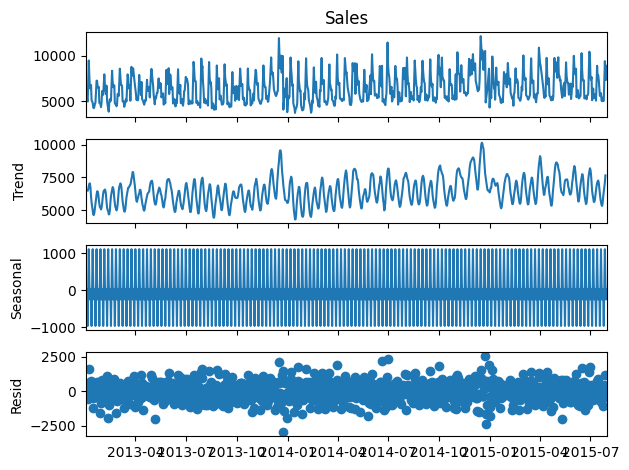

In [39]:
# Time series Decomposition
from pylab import rcParams
import statsmodels.api as sm
# seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(store_sales_resampled.Sales, model='additive')
fig = decomposition.plot()
plt.show()

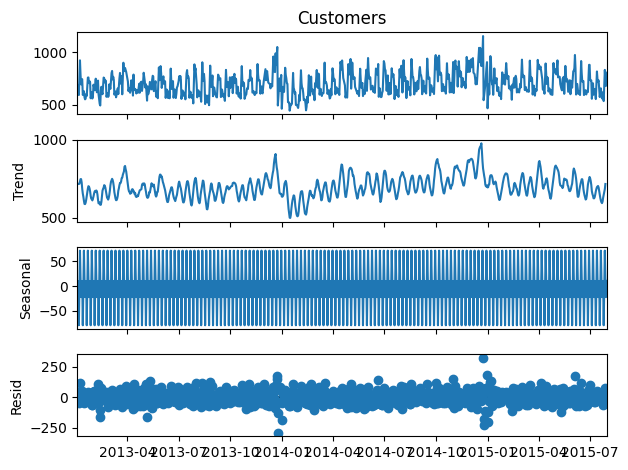

In [40]:
# Time series Decomposition
from pylab import rcParams
import statsmodels.api as sm
# seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(store_sales_resampled.Customers, model='additive')
fig = decomposition.plot()
plt.show()

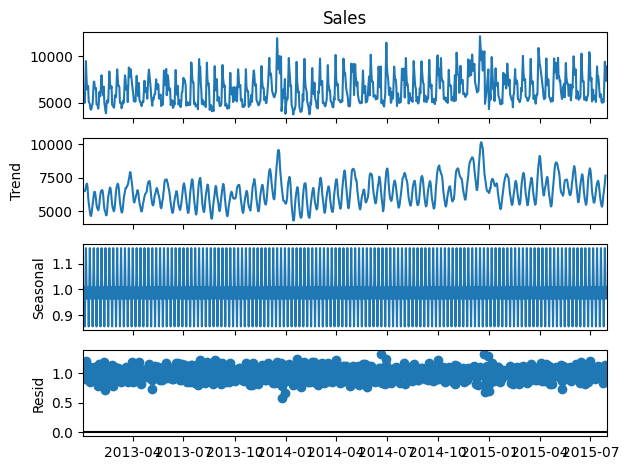

In [41]:
# seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(store_sales_resampled.Sales, model='multiplicative')
fig = decomposition.plot()
plt.show()

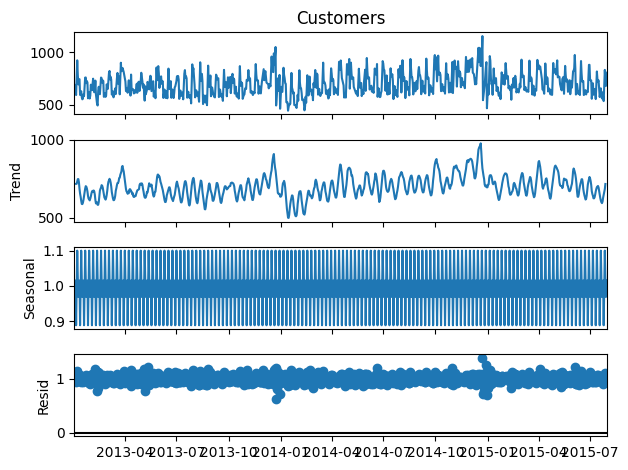

In [42]:
# seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(store_sales_resampled.Customers, model='multiplicative')
fig = decomposition.plot()
plt.show()

 **Model Scope:**
 The scope has been kept to nine key stores across Europe. These stores are numbered - 1,3,8,9,13,25,29,31 and 46.

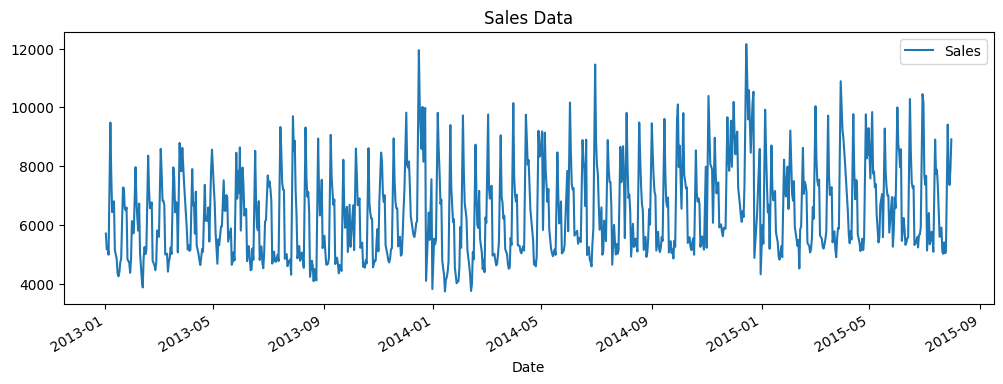

In [43]:
store_sales_grouped['Sales'].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Sales Data')
plt.show(block=False)

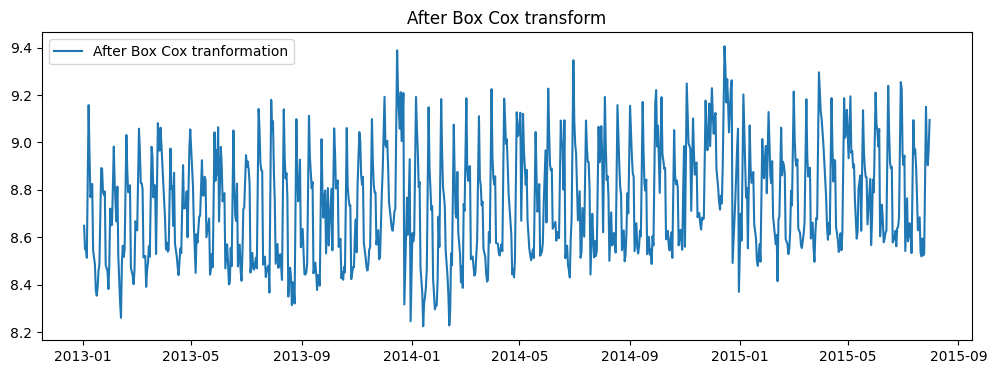

In [46]:
### Box Cox transformation to make variance constant
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(store_sales_grouped['Sales'], lmbda=0), index = store_sales_grouped.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

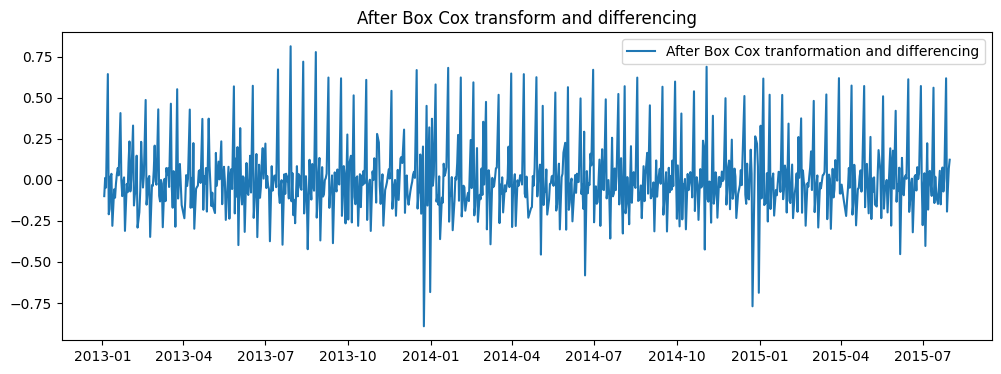

In [47]:
# Differencing
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), store_sales_grouped.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [ ]:
data_boxcox_diff.dropna(inplace=True)

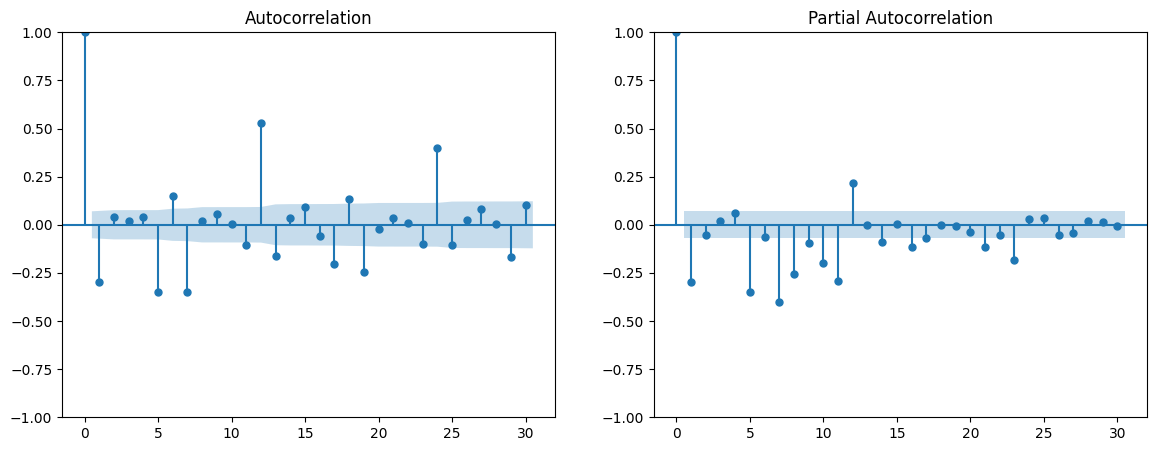

In [66]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(1,2,figsize=(14,5))
sm.graphics.tsa.plot_acf(data_boxcox_diff.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(data_boxcox_diff.squeeze(), lags=30, ax=ax[1])


plt.show()
#q=0 and q=7

In [50]:
store_sales_grouped.head()

,Sales,Customers,Promo,SchoolHoliday,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
Date,,,,,,,,,,
2013-01-02,5702.333333,688.000000,0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-03,5162.444444,636.000000,0,1.000000,0.0,0.0,1.0,0.0,0.0,0.0
2013-01-04,5221.777778,635.666667,0,1.000000,0.0,0.0,0.0,1.0,0.0,0.0
2013-01-05,4981.000000,592.111111,0,0.111111,0.0,0.0,0.0,0.0,1.0,0.0
2013-01-07,9481.777778,922.111111,9,0.111111,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
store_sales_grouped.shape[0]

784

In [63]:
display(store_sales_grouped)

,Sales,Customers,Promo,SchoolHoliday,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
Date,,,,,,,,,,
2013-01-02,5702.333333,688.000000,0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-03,5162.444444,636.000000,0,1.000000,0.0,0.0,1.0,0.0,0.0,0.0
2013-01-04,5221.777778,635.666667,0,1.000000,0.0,0.0,0.0,1.0,0.0,0.0
2013-01-05,4981.000000,592.111111,0,0.111111,0.0,0.0,0.0,0.0,1.0,0.0
2013-01-07,9481.777778,922.111111,9,0.111111,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2015-07-27,9412.555556,831.111111,9,0.666667,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-28,7756.666667,727.333333,9,0.666667,1.0,0.0,0.0,0.0,0.0,0.0
2015-07-29,7358.666667,679.111111,9,0.666667,0.0,1.0,0.0,0.0,0.0,0.0


The Granger causality test assesses whether past values of one time series help predict another time series. The null hypothesis is that the lagged values of the first time series do not provide significant information in predicting the second time series.

In [72]:
from statsmodels.tsa.stattools import grangercausalitytests

causality_sales=grangercausalitytests(store_sales_grouped[['Sales','Customers']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=46.3741 , p=0.0000  , df_denom=780, df_num=1
ssr based chi2 test:   chi2=46.5525 , p=0.0000  , df=1
likelihood ratio test: chi2=45.2211 , p=0.0000  , df=1
parameter F test:         F=46.3741 , p=0.0000  , df_denom=780, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=25.3323 , p=0.0000  , df_denom=777, df_num=2
ssr based chi2 test:   chi2=50.9907 , p=0.0000  , df=2
likelihood ratio test: chi2=49.3972 , p=0.0000  , df=2
parameter F test:         F=25.3323 , p=0.0000  , df_denom=777, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=24.0398 , p=0.0000  , df_denom=774, df_num=3
ssr based chi2 test:   chi2=72.7717 , p=0.0000  , df=3
likelihood ratio test: chi2=69.5782 , p=0.0000  , df=3
parameter F test:         F=24.0398 , p=0.0000  , df_denom=774, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=14.4883 , p=0.0000  

In [76]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(store_sales_grouped['Sales'])
print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -4.324373
Critical Values @ 0.05: -2.87
p-value: 0.000403


The p-value is 0.00 way under than 0.05 and so according to ADF the series is Stationary

In [77]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(store_sales_grouped['Sales'])
print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 2.212879
Critical Values @ 0.05: 0.46
p-value: 0.010000


**ADF test** is showing the series is stationary but **KPSS Test** is showing that the series is not Stationary

If the p-value is below a chosen significance level (e.g., 0.05), it suggests evidence against the null hypothesis. The test indicates casuality between Sales and customers

In [52]:
from datetime import datetime, timedelta

min_date = store_sales_grouped.index.min()
max_date = store_sales_grouped.index.max()

print(min_date, max_date)

#Sunday closed - 6 weeks * 6 days = 36 days
prior_date = max_date - timedelta(days=36)

print(min_date, max_date, prior_date)

2013-01-02 00:00:00 2015-07-31 00:00:00
2013-01-02 00:00:00 2015-07-31 00:00:00 2015-06-25 00:00:00


#### Train / Test Split


In [73]:
train = store_sales_grouped[store_sales_grouped.index < prior_date]
test = store_sales_grouped[store_sales_grouped.index >= prior_date]

endog_vars = ['Sales', 'Customers']
exog_vars = ['Promo','DayOfWeek','SchoolHoliday']

In [68]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 752 entries, 2013-01-02 to 2015-06-24
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sales          752 non-null    float64
 1   Customers      752 non-null    float64
 2   Promo          752 non-null    int64  
 3   SchoolHoliday  752 non-null    int64  
 4   DayOfWeek_2    752 non-null    float64
 5   DayOfWeek_3    752 non-null    float64
 6   DayOfWeek_4    752 non-null    float64
 7   DayOfWeek_5    752 non-null    float64
 8   DayOfWeek_6    752 non-null    float64
 9   DayOfWeek_7    752 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 64.6 KB


In [69]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32 entries, 2015-06-25 to 2015-07-31
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sales          32 non-null     float64
 1   Customers      32 non-null     float64
 2   Promo          32 non-null     int64  
 3   SchoolHoliday  32 non-null     int64  
 4   DayOfWeek_2    32 non-null     float64
 5   DayOfWeek_3    32 non-null     float64
 6   DayOfWeek_4    32 non-null     float64
 7   DayOfWeek_5    32 non-null     float64
 8   DayOfWeek_6    32 non-null     float64
 9   DayOfWeek_7    32 non-null     float64
dtypes: float64(8), int64(2)
memory usage: 2.8 KB


In [74]:
from sklearn.preprocessing import MinMaxScaler
# Fit transform on train data
scaler = MinMaxScaler()
train[['Sales','Customers','Promo','SchoolHoliday']]=scaler.fit_transform(train[['Sales','Customers','Promo','SchoolHoliday']])
train.head()

,Sales,Customers,Promo,SchoolHoliday,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
Date,,,,,,,,,,
2013-01-02,0.234064,0.344902,0.0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-03,0.169957,0.271598,0.0,1.000000,0.0,0.0,1.0,0.0,0.0,0.0
2013-01-04,0.177003,0.271128,0.0,1.000000,0.0,0.0,0.0,1.0,0.0,0.0
2013-01-05,0.148413,0.209729,0.0,0.111111,0.0,0.0,0.0,0.0,1.0,0.0
2013-01-07,0.682837,0.674923,1.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
#Transform on test data

test[['Sales','Customers','Promo','SchoolHoliday']]=scaler.transform(test[['Sales','Customers','Promo','SchoolHoliday']])
test.head()

,Sales,Customers,Promo,SchoolHoliday,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
Date,,,,,,,,,,
2015-06-25,0.227335,0.255935,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0
2015-06-26,0.230330,0.255152,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0
2015-06-27,0.257839,0.249670,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0
2015-06-29,0.797659,0.614620,1.0,0.444444,0.0,0.0,0.0,0.0,0.0,0.0
2015-06-30,0.763198,0.614151,1.0,0.444444,1.0,0.0,0.0,0.0,0.0,0.0


##VAR (Vector Auto Regressive) Model

In [54]:
exog = train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train[['Sales', 'Customers']].astype(float)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        20.82       20.94   1.107e+09       20.87
1        20.44       20.57   7.502e+08       20.49
2        20.35       20.51   6.862e+08       20.41
3        20.33       20.52   6.735e+08       20.40
4        20.31       20.52   6.624e+08       20.39
5        20.28       20.52   6.409e+08       20.37
6        20.26       20.52   6.282e+08       20.36
7        20.11       20.40   5.435e+08       20.22
8        20.07      20.38*   5.215e+08       20.19
9        20.05       20.39   5.125e+08      20.18*
10      20.05*       20.41  5.081e+08*       20.19
11       20.05       20.44   5.109e+08       20.20
12       20.05       20.46   5.084e+08       20.21
13       20.05       20.49   5.106e+08       20.22
14       20.06       20.52   5.158e+08       20.24
15       20.06       20.55   5.168e+08       20.25
-------------------------------

In [62]:
import pandas as pd
import statsmodels.api as sm
from itertools import product

# Assuming you have a DataFrame called train_df with your time series data
# Ensure that 'train' contains the endogenous variable(s)

exog = train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train[['Sales', 'Customers']].astype(float)

# Define the range of AR orders to consider
ar_orders = range(1, 15)  # Adjust the range based on your data characteristics

# Initialize variables to store the best model information
best_aic = float('inf')
best_order = None

# Perform grid search over different AR orders
for ar_order in ar_orders:
    # Create all possible combinations of AR and MA orders
    orders = product([ar_order], [0])  # MA order is set to 0 for simplicity

    # Loop through the combinations
    for order in orders:
        mod = sm.tsa.VARMAX(endog, order=order, trend='n')
        res = mod.fit(maxiter=1000, disp=False)

        # Check if the current model has a lower AIC than the best so far
        if res.aic < best_aic:
            best_aic = res.aic
            best_order = order

# Fit the best model on the entire dataset
best_model = sm.tsa.VARMAX(endog, order=best_order, trend='n')
best_result = best_model.fit(maxiter=1000, disp=False)

# Print the best order and summary of the best model
print("Best Order:", best_order)
print(best_result.summary())


Best Order: (13, 0)
                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  752
Model:                            VAR(13)   Log Likelihood               -9907.988
Date:                    Mon, 26 Feb 2024   AIC                          19925.976
Time:                            05:32:35   BIC                          20180.226
Sample:                                 0   HQIC                         20023.932
                                    - 752                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.05, 0.00   Jarque-Bera (JB):       372.77, 466.48
Prob(Q):                        0.83, 0.99   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.68, 1.38   Skew:                      0.85, -0.34
Prob(H) (two-sided):            0.00, 0.01   Kurtosis:          

In [208]:
train[exog_vars].head()

,Promo,DayOfWeek,SchoolHoliday
Date,,,
2015-06-24,0,3,0
2015-06-24,0,3,0
2015-06-24,0,3,0
2015-06-24,0,3,0
2015-06-24,0,3,0


In [214]:
train.head()

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday
Date,,,,,,
2015-06-24,1,3,3346,414,0,0
2015-06-24,3,3,5448,633,0,0
2015-06-24,8,3,5005,625,0,0
2015-06-24,9,3,6888,620,0,0
2015-06-24,13,3,3056,239,0,0


In [216]:
# Stationarity Test - ADF Test
for endog_var in endog_vars:
    print('\n' + endog_var + ': ADF test results:')

    # Extract the data for the current variable
    current_data = keystore_sales[endog_var].dropna()

    # Perform ADF test
    result = adfuller(current_data)

    # Display ADF test results
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

    # Display Critical Values
    print('Critical Values:')
    for key, value in result[4].items():
        if key == '5%':
            print('\t%s: %.3f' % (key, value))


Sales: ADF test results:
ADF Statistic: -11.683064
p-value: 0.000000
Critical Values:
	5%: -2.862

Customers: ADF test results:
ADF Statistic: -9.760098
p-value: 0.000000
Critical Values:
	5%: -2.862


In [217]:
# VAR does not need exog vars
mod = sm.tsa.VARMAX(train[endog_vars], order=(1,1), trend='n') # p = 1 and q = 1
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                 6336
Model:                         VARMA(1,1)   Log Likelihood              -98520.819
Date:                    Sun, 25 Feb 2024   AIC                         197063.638
Time:                            17:24:29   BIC                         197137.932
Sample:                                 0   HQIC                        197089.367
                                   - 6336                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):          20.69, 154.56   Jarque-Bera (JB):      2463.86, 145.51
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.98, 0.75   Skew:                      1.31, -0.37
Prob(H) (two-sided):            0.61, 0.00   Kurtosis:                   4.56, 3.13
